In [4]:
import os 
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding,LSTM,Dense,Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import nltk
import re


In [5]:
# Specify the filename
input_file=r'holmes.txt'
# Read the content of the file
with open(input_file,'r',encoding='utf-8') as file:
    data=file.read()

In [6]:
# view first few character
data[:100]

"*Project Gutenberg's Etext of Tom Swift And His Submarine Boat*\n\n#4 in the Victor Appleton's Tom Swi"

In [7]:
# Limit data to 500000 character
data = data[:500000]
data

'*Project Gutenberg\'s Etext of Tom Swift And His Submarine Boat*\n\n#4 in the Victor Appleton\'s Tom Swift Series\n\nWe name these Etext files as they are numbered in the books,\n\ni.e. This is #4 in the series so the file name is 04tomxxx.xxx,\n\nwhere the x\'s are place holders for editon # and file type such\n\nas 04tom10.txt and 04tom10.zip, when we do a .htm, 04tom10h.htm\n\n\n\n\n\nCopyright laws are changing all over the world, be sure to check\n\nthe copyright laws for your country before posting these files!!\n\n\n\nPlease take a look at the important information in this header.\n\nWe encourage you to keep this file on your own disk, keeping an\n\nelectronic path open for the next readers.  Do not remove this.\n\n\n\n\n\n**Welcome To The World of Free Plain Vanilla Electronic Texts**\n\n\n\n**Etexts Readable By Both Humans and By Computers, Since 1971**\n\n\n\n*These Etexts Prepared By Hundreds of Volunteers and Donations*\n\n\n\nInformation on contacting Project Gutenberg to

In [8]:
# Function to remove emojis and special character from text
import re

def clean_text(text):
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Remove extra spaces
    text = re.sub(' +', ' ', text)
    
    return text


In [9]:
# Preprocessing pipeline
def text_processing(data) -> list:
    # Split by newline character
    sentences = data.split('\n')
    
    # Clean and tokenize each sentence
    processed_sentences = []
    for sentence in sentences:
        sentence = clean_text(sentence)      # Clean emojis/special chars
        sentence = sentence.strip().lower()  # Trim spaces and lowercase
        
        if sentence:                         # Skip empty sentences
            words = sentence.split()         # Tokenize by splitting words
            processed_sentences.append(words)
    
    return processed_sentences



tokenized_sentences=text_processing(data)
tokenized_sentences

[['project',
  'gutenbergs',
  'etext',
  'of',
  'tom',
  'swift',
  'and',
  'his',
  'submarine',
  'boat'],
 ['4', 'in', 'the', 'victor', 'appletons', 'tom', 'swift', 'series'],
 ['we',
  'name',
  'these',
  'etext',
  'files',
  'as',
  'they',
  'are',
  'numbered',
  'in',
  'the',
  'books'],
 ['ie',
  'this',
  'is',
  '4',
  'in',
  'the',
  'series',
  'so',
  'the',
  'file',
  'name',
  'is',
  '04tomxxxxxx'],
 ['where',
  'the',
  'xs',
  'are',
  'place',
  'holders',
  'for',
  'editon',
  'and',
  'file',
  'type',
  'such'],
 ['as',
  '04tom10txt',
  'and',
  '04tom10zip',
  'when',
  'we',
  'do',
  'a',
  'htm',
  '04tom10hhtm'],
 ['copyright',
  'laws',
  'are',
  'changing',
  'all',
  'over',
  'the',
  'world',
  'be',
  'sure',
  'to',
  'check'],
 ['the',
  'copyright',
  'laws',
  'for',
  'your',
  'country',
  'before',
  'posting',
  'these',
  'files'],
 ['please',
  'take',
  'a',
  'look',
  'at',
  'the',
  'important',
  'information',
  'in',
  'thi

In [10]:
# tokenize words
tokenizer=Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(tokenized_sentences)
total_words=len(tokenizer.word_index)+1
print(f"Total words in vocabulary: {total_words}")
print("Word Index:", tokenizer.word_index)  # Display word index
print("Word Counts:", tokenizer.word_counts)

Total words in vocabulary: 6120
Word Index: {'<oov>': 1, 'the': 2, 'to': 3, 'and': 4, 'of': 5, 'a': 6, 'was': 7, 'he': 8, 'it': 9, 'in': 10, 'i': 11, 'tom': 12, 'you': 13, 'that': 14, 'his': 15, 'mr': 16, 'for': 17, 'on': 18, 'as': 19, 'but': 20, 'had': 21, 'they': 22, 'with': 23, 'be': 24, 'we': 25, 'were': 26, 'at': 27, 'not': 28, 'have': 29, 'there': 30, 'from': 31, 'is': 32, 'this': 33, 'one': 34, 'if': 35, 'all': 36, 'swift': 37, 'by': 38, 'him': 39, 'out': 40, 'well': 41, 'no': 42, 'up': 43, 'some': 44, 'what': 45, 'an': 46, 'my': 47, 'or': 48, 'do': 49, 'get': 50, 'so': 51, 'will': 52, 'them': 53, 'could': 54, 'submarine': 55, 'car': 56, 'then': 57, 'would': 58, 'damon': 59, 'more': 60, 'when': 61, 'captain': 62, 'did': 63, 'sharp': 64, 'about': 65, 'now': 66, 'are': 67, 'me': 68, 'which': 69, 'dont': 70, 'been': 71, 'inventor': 72, 'see': 73, 'go': 74, 'going': 75, 'over': 76, 'can': 77, 'lad': 78, 'cried': 79, 'ill': 80, 'asked': 81, 'after': 82, 'im': 83, 'its': 84, 'young': 

In [11]:
# Generate inpute sequences
input_sequences=[]
for line in tokenized_sentences:
    token_list=tokenizer.texts_to_sequences([line])[0]
    for i in range(1,len(token_list)):
        n_gram_sequence=token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Pad sequences
max_sequence_len=max([len(x) for x in input_sequences])
input_sequences=np.array(pad_sequences(input_sequences,maxlen=max_sequence_len,padding='pre'))


In [12]:
X = input_sequences[:, :-1]
y = input_sequences[:, -1]

# Convert labels to categorical if using a categorical loss function
y = tf.keras.utils.to_categorical(y, num_classes=total_words)


In [17]:
# Split data into training , validation and test set.
from sklearn.model_selection import train_test_split
X_train,X_val_test,y_train,y_val_test=train_test_split(X,y,test_size=0.2,random_state=42)
X_val,X_test,y_val,y_test=train_test_split(X_val_test,y_val_test,test_size=0.5,random_state=42)

In [18]:
# Train test model
from tensorflow.keras.callbacks import EarlyStopping
# Define a model
model=Sequential()
model.add(Embedding(total_words,100))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words,activation='softmax'))
learning_rate=Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',optimizer=learning_rate,metrics=['accuracy'])
#Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 75s 35ms/step - accuracy: 0.0769 - loss: 6.5213 - val_accuracy: 0.1108 - val_loss: 5.8029
Epoch 2/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - accuracy: 0.1249 - loss: 5.4674 - val_accuracy: 0.1393 - val_loss: 5.5466
Epoch 3/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - accuracy: 0.1540 - loss: 5.0129 - val_accuracy: 0.1478 - val_loss: 5.4725
Epoch 4/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - accuracy: 0.1781 - loss: 4.6448 - val_accuracy: 0.1549 - val_loss: 5.4748
Epoch 5/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 76s 38ms/step - accuracy: 0.2016 - loss: 4.3110 - val_accuracy: 0.1594 - val_loss: 5.5265
Epoch 6/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 77s 39ms/step - accuracy: 0.2270 - loss: 4.0257 - val_accuracy: 0.1619 - val_loss: 5.5899


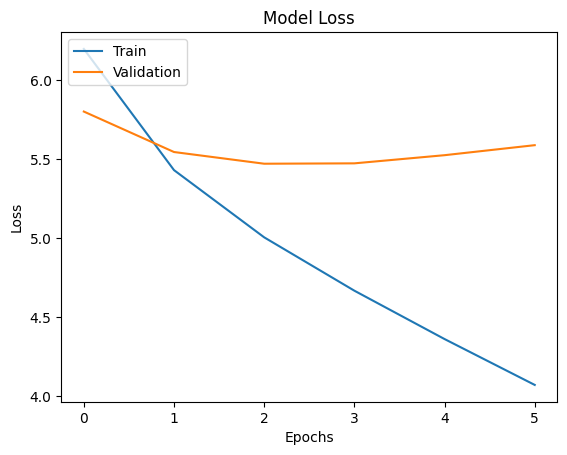

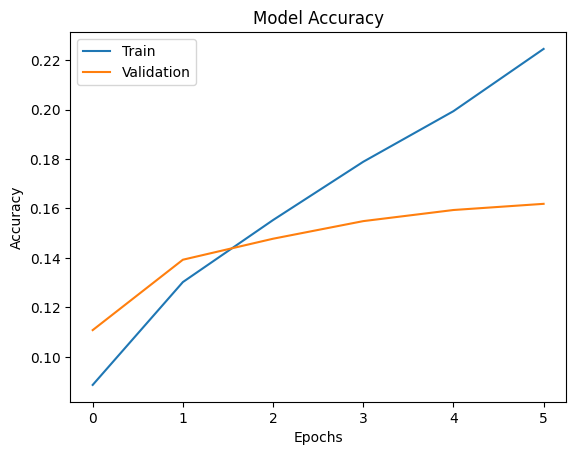

In [21]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")


251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1622 - loss: 5.5285
Test Loss: 5.545574188232422, Test Accuracy: 0.1613588184118271
